# DRAFT Flattent method

(Utiliser l'environnement *data-env*)

L'objectif est d'extraire des cubes de données autour d'un ensemble de points d'observations à partir d'un datacube (time, lon, lat).

## Configuration

### Librairies

In [1]:
import sys
import time
from pathlib import Path
from datetime import datetime, timedelta

import intake
import numpy as np
import pandas as pd
import xarray as xr
from dask.distributed import LocalCluster, Client
from IPython.display import display

sys.path.insert(0, '../..')
from histlib.observations import (
    generate_virtual_observations,
    plot_observations,
)

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Observations

In [137]:
N = 100 # Nombre de points d'observations
extent = (-180, 180, -90, 90) # Extension spatiale (lon_min, lon_max, lat_min, lat_max)
period = ('2000-01-01', '2001-01-01') # Extension temporelle (start_date, end_date)

In [138]:
# Génération des points d'observations
ds = generate_virtual_observations(N, extent, period)

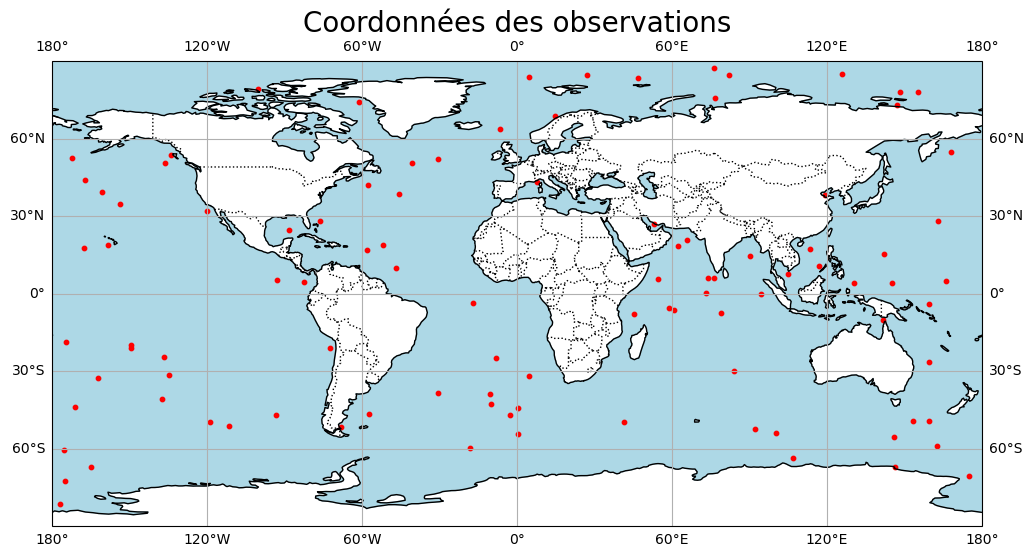

In [139]:
# Affichage sur une carte
plot_observations(ds)

## Datacube

In [17]:
dataset = 'aviso' # Nom du jeu de données (aviso / erastar)
name = 'datacube-1' # Nom du datacube

In [18]:
# Définir la taille des chunks
chunks = dict(time=5, lat=50, lon=50)

In [8]:
%%time
# Chargement du datacube
WRK = Path(f'/home1/datawork/gcaer/data/{dataset}/{name}')
cat = intake.open_catalog(WRK / f"references/aviso/reference.yaml")
datacube = cat["data"](chunks={"time": chunks['time'], "latitude": chunks['lat'], "longitude": chunks['lon']}).to_dask()

CPU times: user 6.19 s, sys: 884 ms, total: 7.07 s
Wall time: 12.9 s


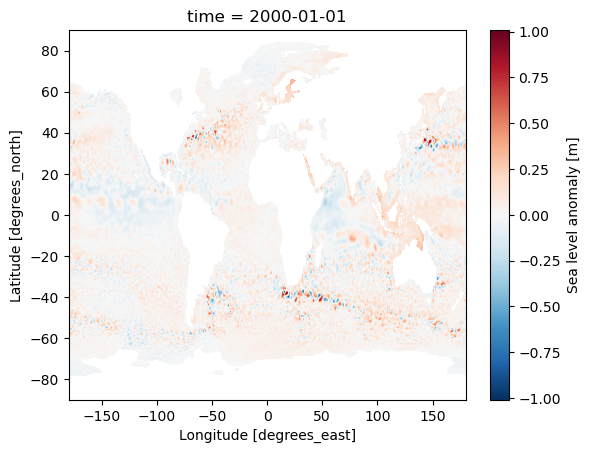

In [9]:
datacube.isel(time=0).sla.plot()

## Select cubes

In [29]:
obs = ds.isel(obs=0)

# Sélection dans le datacube
dl = 0.25
dt = 1
dlon = 0.75
dlat = 0.5

start, end = obs.time + pd.Timedelta(days=-dt), obs.time + pd.Timedelta(days=dt+1)
lon_min, lon_max = obs.lon.values - dlon, obs.lon.values + dlon
lat_min, lat_max = obs.lat.values - dlat, obs.lat.values + dlat

it = np.r_[slice(start.values, end.values, timedelta(days=1))]
ilo = np.r_[slice(lon_min, lon_max, dl)]
ila = np.r_[slice(lat_min, lat_max, dl)]

### Cube de référence (avec slice)

On réalise un 1er test sur une seul observation, avec des slices ce sera notre cube de réferrence sur lequel on doit retomber

In [23]:
cref = datacube.sel(time=it, longitude=ilo, latitude=ila, method="nearest").compute()

In [24]:
cref

<xarray.Dataset>
Dimensions:         (time: 3, latitude: 4, longitude: 6, nv: 2)
Coordinates:
  * latitude        (latitude) float32 7.125 7.375 7.625 7.875
  * longitude       (longitude) float32 70.38 70.62 70.88 71.12 71.38 71.62
  * nv              (nv) int32 0 1
  * time            (time) datetime64[ns] 2000-08-13 2000-08-14 2000-08-15
Data variables: (12/14)
    adt             (time, latitude, longitude) float64 0.689 0.6842 ... 0.6616
    crs             (time) float64 nan nan nan
    err_sla         (time, latitude, longitude) float64 0.011 0.0115 ... 0.0155
    err_ugosa       (time, latitude, longitude) float64 0.0791 0.0833 ... 0.1044
    err_vgosa       (time, latitude, longitude) float64 0.0983 0.0971 ... 0.1402
    flag_ice        (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0
    ...              ...
    sla             (time, latitude, longitude) float64 -0.0675 ... -0.0932
    tpa_correction  (time) float64 0.0 0.0 0.0
    ugos            (time, latitude, longitude) float64 0.0531 0.0678 ... 0.0131
    ugosa           (time, latitude, longitude) float64 0.04 0.0525 ... 0.0199
    vgos            (time, latitude, longitude) float64 -0.1193 ... -0.171
    vgosa           (time, latitude, longitude) float64 -0.1298 ... -0.1841
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2000-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1999-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [25]:
for name, var in cref.variables.items():
    display((var.dims, var.values.shape, var.values.size))

(('time', 'latitude', 'longitude'), (3, 4, 6), 72)

(('time',), (3,), 3)

(('time', 'latitude', 'longitude'), (3, 4, 6), 72)

(('time', 'latitude', 'longitude'), (3, 4, 6), 72)

(('time', 'latitude', 'longitude'), (3, 4, 6), 72)

(('time', 'latitude', 'longitude'), (3, 4, 6), 72)

(('time', 'latitude', 'nv'), (3, 4, 2), 24)

(('latitude',), (4,), 4)

(('time', 'longitude', 'nv'), (3, 6, 2), 36)

(('longitude',), (6,), 6)

(('nv',), (2,), 2)

(('time', 'latitude', 'longitude'), (3, 4, 6), 72)

(('time',), (3,), 3)

(('time',), (3,), 3)

(('time', 'latitude', 'longitude'), (3, 4, 6), 72)

(('time', 'latitude', 'longitude'), (3, 4, 6), 72)

(('time', 'latitude', 'longitude'), (3, 4, 6), 72)

(('time', 'latitude', 'longitude'), (3, 4, 6), 72)

In [26]:
cref.adt.values

array([[[0.689 , 0.6842, 0.6828, 0.6789, 0.6778, 0.6734],
        [0.6861, 0.682 , 0.6804, 0.6785, 0.6735, 0.6713],
        [0.684 , 0.6804, 0.6761, 0.6753, 0.672 , 0.6664],
        [0.6821, 0.6754, 0.6748, 0.6729, 0.6702, 0.6627]],

       [[0.6855, 0.6825, 0.6797, 0.6775, 0.6764, 0.6722],
        [0.6828, 0.6801, 0.6767, 0.6763, 0.6725, 0.6709],
        [0.6807, 0.6796, 0.6783, 0.6779, 0.673 , 0.6664],
        [0.6801, 0.6817, 0.6805, 0.6773, 0.671 , 0.6629]],

       [[0.6828, 0.6804, 0.6756, 0.6758, 0.6731, 0.6692],
        [0.6829, 0.6787, 0.6781, 0.6749, 0.672 , 0.6671],
        [0.6823, 0.6819, 0.6803, 0.6777, 0.6724, 0.6647],
        [0.6798, 0.6826, 0.6797, 0.6767, 0.6699, 0.6616]]])

In [27]:
cref.lon_bnds.values

array([[[70.25, 70.5 ],
        [70.5 , 70.75],
        [70.75, 71.  ],
        [71.  , 71.25],
        [71.25, 71.5 ],
        [71.5 , 71.75]],

       [[70.25, 70.5 ],
        [70.5 , 70.75],
        [70.75, 71.  ],
        [71.  , 71.25],
        [71.25, 71.5 ],
        [71.5 , 71.75]],

       [[70.25, 70.5 ],
        [70.5 , 70.75],
        [70.75, 71.  ],
        [71.  , 71.25],
        [71.25, 71.5 ],
        [71.5 , 71.75]]], dtype=float32)

In [28]:
cref.lat_bnds.values

array([[[7.  , 7.25],
        [7.25, 7.5 ],
        [7.5 , 7.75],
        [7.75, 8.  ]],

       [[7.  , 7.25],
        [7.25, 7.5 ],
        [7.5 , 7.75],
        [7.75, 8.  ]],

       [[7.  , 7.25],
        [7.25, 7.5 ],
        [7.5 , 7.75],
        [7.75, 8.  ]]], dtype=float32)

#### Cube de test (avec flatten) 

In [62]:
# Créer des grilles multidimensionnelles
gt, gla, glo = np.meshgrid(it, ila, ilo, indexing='ij')
    
# Mise à plat des indices
ft = gt.flatten()
fla = gla.flatten()
flo = glo.flatten()

In [63]:
cr = datacube.sel(
    time=xr.DataArray(ft,  dims="points"),
    longitude=xr.DataArray(flo,  dims="points"),
    latitude=xr.DataArray(fla,  dims="points"),
    method="nearest",
).compute()

In [64]:
cr

<xarray.Dataset>
Dimensions:         (points: 72, nv: 2)
Coordinates:
    latitude        (points) float32 7.125 7.125 7.125 ... 7.875 7.875 7.875
    longitude       (points) float32 70.38 70.62 70.88 ... 71.12 71.38 71.62
  * nv              (nv) int32 0 1
    time            (points) datetime64[ns] 2000-08-13 2000-08-13 ... 2000-08-15
Dimensions without coordinates: points
Data variables: (12/14)
    adt             (points) float64 0.689 0.6842 0.6828 ... 0.6699 0.6616
    crs             (points) float64 nan nan nan nan nan ... nan nan nan nan nan
    err_sla         (points) float64 0.011 0.0115 0.013 ... 0.0164 0.0153 0.0155
    err_ugosa       (points) float64 0.0791 0.0833 0.092 ... 0.1014 0.1044
    err_vgosa       (points) float64 0.0983 0.0971 0.0937 ... 0.1258 0.1402
    flag_ice        (points) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...              ...
    sla             (points) float64 -0.0675 -0.0732 -0.0753 ... -0.0843 -0.0932
    tpa_correction  (points) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ugos            (points) float64 0.0531 0.0678 0.0197 ... 0.0104 0.0131
    ugosa           (points) float64 0.04 0.0525 0.0017 ... 0.0064 0.0199
    vgos            (points) float64 -0.1193 -0.0645 -0.0757 ... -0.1365 -0.171
    vgosa           (points) float64 -0.1298 -0.0648 -0.0665 ... -0.1453 -0.1841
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2000-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1999-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [65]:
for name, var in cr.variables.items():
    display((var.dims, var.values.shape, var.values.size))

(('points',), (72,), 72)

(('points',), (72,), 72)

(('points',), (72,), 72)

(('points',), (72,), 72)

(('points',), (72,), 72)

(('points',), (72,), 72)

(('points', 'nv'), (72, 2), 144)

(('points',), (72,), 72)

(('points', 'nv'), (72, 2), 144)

(('points',), (72,), 72)

(('nv',), (2,), 2)

(('points',), (72,), 72)

(('points',), (72,), 72)

(('points',), (72,), 72)

(('points',), (72,), 72)

(('points',), (72,), 72)

(('points',), (72,), 72)

(('points',), (72,), 72)

In [66]:
cr.adt.values.reshape(3, 4, 6) == cref.adt.values

array([[[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True]]])

In [67]:
cr.lon_bnds.values.reshape(3, 4, 6, 2)[:, 0, :, :] == cref.lon_bnds.values

array([[[ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True]]])

In [68]:
cr.lat_bnds.values.reshape(3, 4, 6, 2)[:, :, 0, :] == cref.lat_bnds.values

array([[[ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True]]])

In [99]:
# Mise en forme
default_indexers = ('time', 'latitude', 'longitude',)
indexers = {}
for name, var in datacube.variables.items():
    indexers[name] = tuple([k for k in default_indexers if k in var.dims])
indexers

{'adt': ('time', 'latitude', 'longitude'),
 'crs': ('time',),
 'err_sla': ('time', 'latitude', 'longitude'),
 'err_ugosa': ('time', 'latitude', 'longitude'),
 'err_vgosa': ('time', 'latitude', 'longitude'),
 'flag_ice': ('time', 'latitude', 'longitude'),
 'lat_bnds': ('time', 'latitude'),
 'latitude': ('latitude',),
 'lon_bnds': ('time', 'longitude'),
 'longitude': ('longitude',),
 'nv': (),
 'sla': ('time', 'latitude', 'longitude'),
 'time': ('time',),
 'tpa_correction': ('time',),
 'ugos': ('time', 'latitude', 'longitude'),
 'ugosa': ('time', 'latitude', 'longitude'),
 'vgos': ('time', 'latitude', 'longitude'),
 'vgosa': ('time', 'latitude', 'longitude')}

In [102]:
variables = {}
for name, var in cr.variables.items():
    ind, shp, slc = (), (), ()
    for k, v in var.sizes.items():
        if k == 'points':
            ind += indexers[name]
            shp += (3, 4, 6)
            if 'time' in indexers[name]:
                slc += (slice(None),)
            else:
                slc += (0,)
            if 'latitude' in indexers[name]:
                slc += (slice(None),)
            else:
                slc += (0,)
            if 'longitude' in indexers[name]:
                slc += (slice(None),)
            else:
                slc += (0,)
        else:
            ind += (k,)
            shp += (v,)
            slc += (slice(None),)
            
    new_arr = var.values.reshape(shp)[slc]
    new_var = xr.Variable(ind, new_arr)
    
    variables[name] = new_var
    
    print(name, ind, shp, slc)
    
#coord_names = cr._coord_names & variables.keys()

adt ('time', 'latitude', 'longitude') (3, 4, 6) (slice(None, None, None), slice(None, None, None), slice(None, None, None))
crs ('time',) (3, 4, 6) (slice(None, None, None), 0, 0)
err_sla ('time', 'latitude', 'longitude') (3, 4, 6) (slice(None, None, None), slice(None, None, None), slice(None, None, None))
err_ugosa ('time', 'latitude', 'longitude') (3, 4, 6) (slice(None, None, None), slice(None, None, None), slice(None, None, None))
err_vgosa ('time', 'latitude', 'longitude') (3, 4, 6) (slice(None, None, None), slice(None, None, None), slice(None, None, None))
flag_ice ('time', 'latitude', 'longitude') (3, 4, 6) (slice(None, None, None), slice(None, None, None), slice(None, None, None))
lat_bnds ('time', 'latitude', 'nv') (3, 4, 6, 2) (slice(None, None, None), slice(None, None, None), 0, slice(None, None, None))
latitude ('latitude',) (3, 4, 6) (0, slice(None, None, None), 0)
lon_bnds ('time', 'longitude', 'nv') (3, 4, 6, 2) (slice(None, None, None), 0, slice(None, None, None), slice(

In [103]:
cr.longitude.values.reshape(3, 4, 6)[]

SyntaxError: invalid syntax (2125586627.py, line 1)

In [104]:
variables['latitude']

<xarray.Variable (latitude: 4)>
array([7.125, 7.375, 7.625, 7.875], dtype=float32)

In [105]:
variables['longitude']

<xarray.Variable (longitude: 6)>
array([70.375, 70.625, 70.875, 71.125, 71.375, 71.625], dtype=float32)

In [106]:
cr_reshape = cr._replace_with_new_dims(variables, coord_names, indexes={})

In [108]:
cref

<xarray.Dataset>
Dimensions:         (time: 3, latitude: 4, longitude: 6, nv: 2)
Coordinates:
  * latitude        (latitude) float32 7.125 7.375 7.625 7.875
  * longitude       (longitude) float32 70.38 70.62 70.88 71.12 71.38 71.62
  * nv              (nv) int32 0 1
  * time            (time) datetime64[ns] 2000-08-13 2000-08-14 2000-08-15
Data variables: (12/14)
    adt             (time, latitude, longitude) float64 0.689 0.6842 ... 0.6616
    crs             (time) float64 nan nan nan
    err_sla         (time, latitude, longitude) float64 0.011 0.0115 ... 0.0155
    err_ugosa       (time, latitude, longitude) float64 0.0791 0.0833 ... 0.1044
    err_vgosa       (time, latitude, longitude) float64 0.0983 0.0971 ... 0.1402
    flag_ice        (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0
    ...              ...
    sla             (time, latitude, longitude) float64 -0.0675 ... -0.0932
    tpa_correction  (time) float64 0.0 0.0 0.0
    ugos            (time, latitude, longitude) float64 0.0531 0.0678 ... 0.0131
    ugosa           (time, latitude, longitude) float64 0.04 0.0525 ... 0.0199
    vgos            (time, latitude, longitude) float64 -0.1193 ... -0.171
    vgosa           (time, latitude, longitude) float64 -0.1298 ... -0.1841
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2000-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1999-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [107]:
cr_reshape

<xarray.Dataset>
Dimensions:         (time: 3, latitude: 4, longitude: 6, nv: 2)
Coordinates:
    latitude        (latitude) float32 7.125 7.375 7.625 7.875
    longitude       (longitude) float32 70.38 70.62 70.88 71.12 71.38 71.62
    nv              (nv) int32 0 1
    time            (time) datetime64[ns] 2000-08-13 2000-08-14 2000-08-15
Data variables: (12/14)
    adt             (time, latitude, longitude) float64 0.689 0.6842 ... 0.6616
    crs             (time) float64 nan nan nan
    err_sla         (time, latitude, longitude) float64 0.011 0.0115 ... 0.0155
    err_ugosa       (time, latitude, longitude) float64 0.0791 0.0833 ... 0.1044
    err_vgosa       (time, latitude, longitude) float64 0.0983 0.0971 ... 0.1402
    flag_ice        (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0
    ...              ...
    sla             (time, latitude, longitude) float64 -0.0675 ... -0.0932
    tpa_correction  (time) float64 0.0 0.0 0.0
    ugos            (time, latitude, longitude) float64 0.0531 0.0678 ... 0.0131
    ugosa           (time, latitude, longitude) float64 0.04 0.0525 ... 0.0199
    vgos            (time, latitude, longitude) float64 -0.1193 ... -0.171
    vgosa           (time, latitude, longitude) float64 -0.1298 ... -0.1841
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2000-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1999-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

## Test Fonction

In [140]:
# Mise en forme
default_indexers = ('time', 'latitude', 'longitude',)
indexers = {}
for name, var in datacube.variables.items():
    indexers[name] = tuple([k for k in default_indexers if k in var.dims])
indexers

{'adt': ('time', 'latitude', 'longitude'),
 'crs': ('time',),
 'err_sla': ('time', 'latitude', 'longitude'),
 'err_ugosa': ('time', 'latitude', 'longitude'),
 'err_vgosa': ('time', 'latitude', 'longitude'),
 'flag_ice': ('time', 'latitude', 'longitude'),
 'lat_bnds': ('time', 'latitude'),
 'latitude': ('latitude',),
 'lon_bnds': ('time', 'longitude'),
 'longitude': ('longitude',),
 'nv': (),
 'sla': ('time', 'latitude', 'longitude'),
 'time': ('time',),
 'tpa_correction': ('time',),
 'ugos': ('time', 'latitude', 'longitude'),
 'ugosa': ('time', 'latitude', 'longitude'),
 'vgos': ('time', 'latitude', 'longitude'),
 'vgosa': ('time', 'latitude', 'longitude')}

In [141]:
def ds_reshape(cr):
    variables = {}
    for name, var in cr.variables.items():
        ind, shp, slc = (), (), ()
        for k, v in var.sizes.items():
            if k == 'points':
                ind += indexers[name]
                shp += (3, 4, 6)
                if 'time' in indexers[name]:
                    slc += (slice(None),)
                else:
                    slc += (0,)
                if 'latitude' in indexers[name]:
                    slc += (slice(None),)
                else:
                    slc += (0,)
                if 'longitude' in indexers[name]:
                    slc += (slice(None),)
                else:
                    slc += (0,)
            else:
                ind += (k,)
                shp += (v,)
                slc += (slice(None),)

        new_arr = var.values.reshape(shp)[slc]
        new_var = xr.Variable(ind, new_arr)

        variables[name] = new_var

    coord_names = cr._coord_names & variables.keys()
    return cr._replace_with_new_dims(variables, coord_names, indexes={})

In [142]:
%%time
# Génération des slices des cubes à partir des observations
s_time, s_lat, s_lon = [], [] , []
for idx, obs in enumerate(ds.obs):
    
    start, end = obs.time + pd.Timedelta(days=-dt), obs.time + pd.Timedelta(days=dt+1)
    lon_min, lon_max = obs.lon - dlon, obs.lon + dlon
    lat_min, lat_max = obs.lat - dlat, obs.lat + dlat
    
    s_time.append(slice(start.values, end.values, timedelta(days=1)))
    s_lat.append(slice(lat_min, lat_max, dl))
    s_lon.append(slice(lon_min, lon_max, dl))

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 100 ms


In [143]:
%%time
# Génération des listes d'indices à plat à partir des slices
f_time, f_lat, f_lon = [], [], []
pos, shapes = [], []
n=0
for st, sla, slo in zip(s_time, s_lat, s_lon):
    
    # Générer les indices pour chaque dimension de l'observation en cours
    it = np.r_[st]
    ila = np.r_[sla]
    ilo = np.r_[slo]

    # Créer des grilles multidimensionnelles
    gt, gla, glo = np.meshgrid(it, ila, ilo, indexing='ij')

    # Mise à plat des indices
    ft = gt.flatten()
    fla = gla.flatten()
    flo = glo.flatten()

    # Ajouter les indices à plat du cube, dans la liste des indices à plat
    f_time.extend(ft)
    f_lat.extend(fla)
    f_lon.extend(flo)

    # Enregistre la dimension du cube
    shapes.append((len(it), len(ila), len(ilo)))
    
    # Enregistre les indices correspondant au cube
    n1 = n + len(ft)
    pos.append(slice(n, n1))       
    n = n1

CPU times: user 280 ms, sys: 0 ns, total: 280 ms
Wall time: 282 ms


In [144]:
%%time
# Sélection dans le datacube
result = datacube.sel(
    time=xr.DataArray(f_time,  dims="points"),
    longitude=xr.DataArray(f_lon,  dims="points"),
    latitude=xr.DataArray(f_lat,  dims="points"),
    method="nearest",
).compute()

CPU times: user 3.38 s, sys: 7.88 s, total: 11.3 s
Wall time: 45.2 s


In [134]:
%%time
# A partir de la liste unique on récupère les listes de valeurs de chaque observation
arrs = []
for p in pos:
    arrs.append(result.sel(points=p))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.62 ms


In [135]:
%%time
# Pour chaque cube on remet en forme le cube
results = []
for idx, (arr, shape) in enumerate(zip(arrs, shapes)):
    results.append(ds_reshape(arr))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.33 ms


In [136]:
results

[<xarray.Dataset>
 Dimensions:         (time: 3, latitude: 4, longitude: 6, nv: 2)
 Coordinates:
     latitude        (latitude) float32 -73.88 -73.62 -73.38 -73.12
     longitude       (longitude) float32 -178.6 -178.4 -178.1 ... -177.6 -177.4
     nv              (nv) int32 0 1
     time            (time) datetime64[ns] 2000-11-02 2000-11-03 2000-11-04
 Data variables: (12/14)
     adt             (time, latitude, longitude) float64 nan nan ... -1.242
     crs             (time) float64 nan nan nan
     err_sla         (time, latitude, longitude) float64 nan nan ... 0.01 0.01
     err_ugosa       (time, latitude, longitude) float64 nan nan ... 0.0151
     err_vgosa       (time, latitude, longitude) float64 nan nan ... 0.024 0.024
     flag_ice        (time, latitude, longitude) float64 nan nan nan ... 1.0 1.0
     ...              ...
     sla             (time, latitude, longitude) float64 nan nan ... 0.0246
     tpa_correction  (time) float64 0.0 0.0 0.0
     ugos            (time,